# ISS NAC sky mosaic -- E17 sequence (2012)

This notebook projects Imaging Science Subsystem, Narrow Angle Camera (ISS NAC) images onto the sky captured during Cassini's targeted flyby E17. A comparison between the ISS & VIMS mosaics is shown at the end.

In [25]:
from scripts.project_defs import *
import matplotlib.image as mpimg
from matplotlib.path import Path
from matplotlib.patches import PathPatch, Circle

Load spice kernels, metadata of ISS images, and choose filter of interest.
Image metadata from [OPUS](https://opus.pds-rings.seti.org/#/cols=opusid,instrument,planet,target,time1,observationduration&widgets=instrument,observationtype,target&order=time1,opusid&view=search&browse=gallery&cart_browse=gallery&startobs=1&cart_startobs=1&detail=) and NAC corner coordinates from SPICE are combined to create mosaics.

In [30]:
# load SPICE kernels
METAKR = "../data/cassMetaK.txt"
SCLKID = -82  # cassini spice id
spice.furnsh(METAKR)

# load metadata from ISS images (retrieved from OPUS)
meta_data = pd.read_csv("../data/E17_quad_end_data.csv")

# select which filter images to plot
# filter = "IR3"
filter = "IR1"
# filter = "RED"
# filter = "BL1"
filtered_meta_data = meta_data[meta_data["Filter [Cassini ISS]"] == filter]

# Extract the 'Observation Start Time (YMDhms)' data from the filtered DataFrame
start_time = filtered_meta_data["Observation Start Time (YMDhms)"]
# Convert 'Observation Start Time (YMDhms)' to datetime
start_time_date = pd.to_datetime(filtered_meta_data['Observation Start Time (YMDhms)'])
# Calculate mid-time
mid_time = start_time_date + pd.to_timedelta(filtered_meta_data['Observation Duration (secs)'] / 2, unit='s')
end_time = start_time_date + pd.to_timedelta(filtered_meta_data['Observation Duration (secs)'], unit='s')

opus_ids = list(filtered_meta_data["OPUS ID"])
pds_ids = list(filtered_meta_data["PDS ID"])
filters = list(filtered_meta_data["Filter [Cassini ISS]"])
# example of meta data
print(filtered_meta_data.iloc[-1])

OPUS ID                                 co-iss-n1711553502
PDS ID                                         N1711553502
Filter [Cassini ISS]                                   IR1
Observation Start Time (YMDhms)    2012-03-27T14:40:06.141
Observation Stop Time (YMDhms)     2012-03-27T14:40:18.141
Observation Duration (secs)                           12.0
Declination (Min) (degrees)                      -6.580549
Declination (Max) (degrees)                      -6.192336
Right Ascension (Min) (degrees)                  10.105535
Right Ascension (Max) (degrees)                  10.496214
Name: 17, dtype: object


Project each ISS image on the sky for chosen filter.

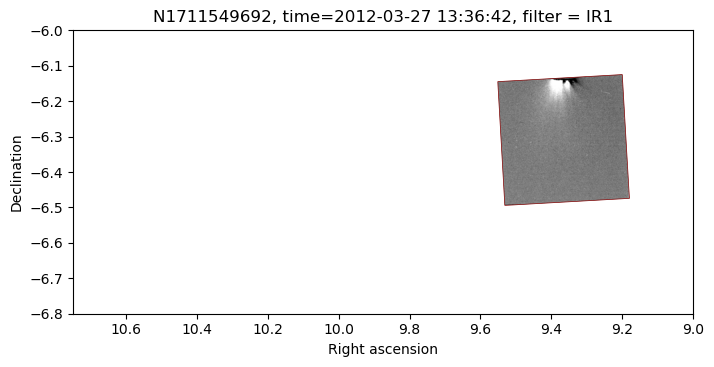

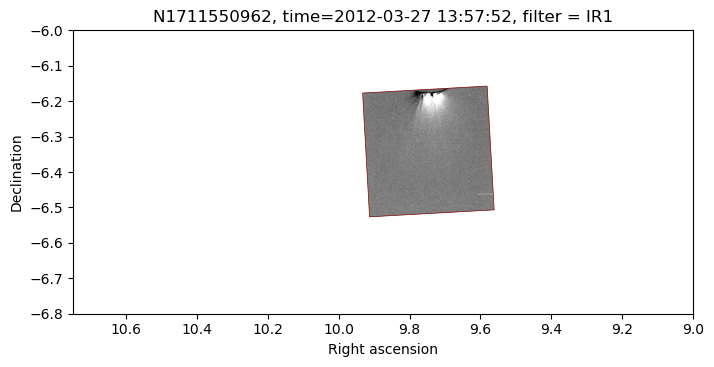

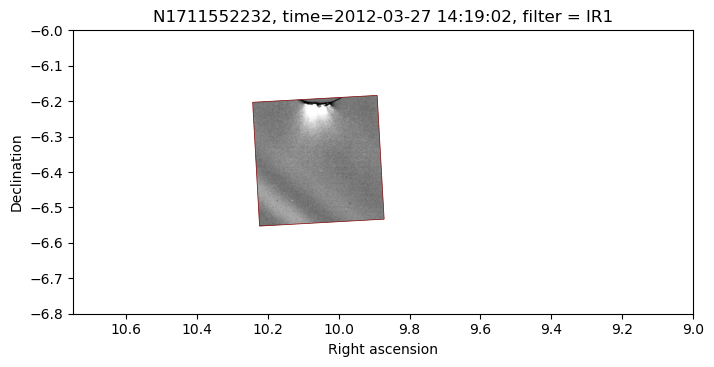

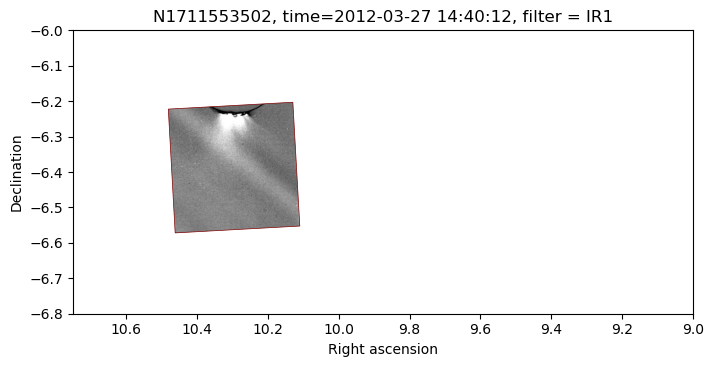

In [20]:
j=0
# loop over each image mid-time
for time in mid_time:

    fig, ax =plt.subplots(figsize=(8, 4))

    [shape, insfrm, bsight, n, bounds] = spice.getfvn("CASSINI_ISS_NAC", 4) # get fov
    pform = spice.pxform("CASSINI_ISS_NAC", 'J2000', spice.str2et(str(time))) # get transformation matrix from NAC to J2000 for image mid-time
    ra_list = []
    dec_list = []
    for i in range(len(bounds)):
        # transform image corner coordinates to J2000 ref frame
        bounds[i] = spice.mxv(pform, bounds[i])
        dist, ra, dec = spice.recrad(bounds[i])
        ra_deg = np.rad2deg(ra)
        dec_deg =np.rad2deg(dec)
        ra_list.append(ra_deg)
        dec_list.append(dec_deg)

    ra_list.append(ra_list[0])
    dec_list.append(dec_list[0])

    # Load the image
    opus_id = opus_ids[j]
    pds_id = pds_ids[j]
    filter = filters[j]
    # retrieve ISS subtracted images from pds_id (nearest clear filter images are subtracted from colour filtered ones)
    img = mpimg.imread(f"../data/isis_E17_subclear/{pds_id}.png")
    img = np.fliplr(img.reshape(-1,3)).reshape(img.shape)

    # Create path for the patch
    path = Path(np.column_stack([ra_list, dec_list]))
    if filter == "RED":
        fcolor ="r"
    elif  filter == "BL1":
        fcolor = "blue"
    elif filter == "IR1":
        fcolor = "maroon"
    else:
        fcolor = "black"
    patch = PathPatch(path, facecolor='none', edgecolor=fcolor, lw=0.5)
    ax.add_patch(patch)

    # Display the image with the patch as clipping path
    im = ax.imshow(img, interpolation='bilinear', origin='lower', cmap=None,
                   extent=[min(ra_list), max(ra_list), min(dec_list), max(dec_list)],
                   clip_path=patch, clip_on=True, alpha=1)

    im.set_clip_path(patch)
    j+=1
    formatted_time = time.strftime("%Y-%m-%d %H:%M:%S")

    plt.gca().set_aspect('equal')
    plt.ylim(-6.8, -6)
    plt.xlim(11, 2)
    plt.xlim(10.75, 9)
    plt.xlabel("Right ascension")
    plt.ylabel("Declination")
    plt.title(f"{pds_id}, time={formatted_time}, filter = {filter}")
    plt.show()

Create ISS projection mosaic for every image in every filter.

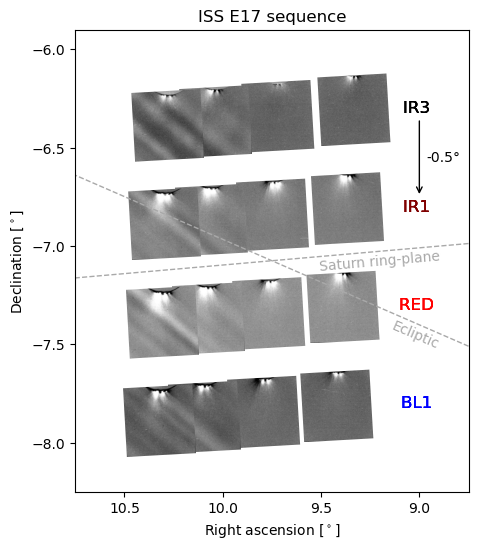

In [22]:
# select all metadata except for clear filtered images
filtered_meta_data = meta_data[meta_data["Filter [Cassini ISS]"] != "CLEAR"]

# Extract the 'Observation Start Time (YMDhms)' data from the filtered DataFrame
start_time = filtered_meta_data["Observation Start Time (YMDhms)"]
# Convert 'Observation Start Time (YMDhms)' to datetime
start_time_date = pd.to_datetime(filtered_meta_data['Observation Start Time (YMDhms)'])
# Calculate mid-time
mid_time = start_time_date + pd.to_timedelta(filtered_meta_data['Observation Duration (secs)'] / 2, unit='s')
end_time = start_time_date + pd.to_timedelta(filtered_meta_data['Observation Duration (secs)'], unit='s')

opus_ids = list(filtered_meta_data["OPUS ID"])
pds_ids = list(filtered_meta_data["PDS ID"])
filters = list(filtered_meta_data["Filter [Cassini ISS]"])

fig, ax =plt.subplots(figsize=(6, 6))
j=0
b_ra_list = []
b_dec_list = []
for time in mid_time:

    [shape, insfrm, bsight, n, bounds] = spice.getfvn("CASSINI_ISS_NAC", 4) # get fov
    pform = spice.pxform("CASSINI_ISS_NAC", 'J2000', spice.datetime2et(time)) # get transformation matrix from Cassini to J2000

    ra_list = []
    dec_list = []
    for i in range(len(bounds)):
        # retrieve image corners during observation mid-time
        bounds[i] = spice.mxv(pform, bounds[i])
        dist, ra, dec = spice.recrad(bounds[i])
        ra_deg = np.rad2deg(ra)
        dec_deg =np.rad2deg(dec)
        ra_list.append(ra_deg)
        dec_list.append(dec_deg)

    ra_list.append(ra_list[0])
    dec_list.append(dec_list[0])

    #boresight
    bsight_j2000 = spice.mxv(pform, bsight)
    b_dist, b_ra, b_dec = spice.recrad(bsight_j2000)
    b_ra_list.append(b_ra)
    b_dec_list.append(b_dec)

    # Load the image metadata
    opus_id = opus_ids[j]
    pds_id = pds_ids[j]
    filter = filters[j]

    # load subtracted images (nearest clear filter images are subtracted from colour filtered ones)
    img = mpimg.imread(f"../data/isis_E17_subclear/{pds_id}.png")
    img = np.fliplr(img.reshape(-1,3)).reshape(img.shape)

    if filter == "RED":
        fcolor ="r"
        offset = -1
    elif  filter == "BL1":
        fcolor = "blue"
        offset = -1.5
    elif filter == "IR1":
        fcolor = "maroon"
        offset = -0.5
    elif filter =="CLEAR":
        fcolor ="grey"
        offset = + 0.5
    else:
        fcolor = "black"
        offset = 0

    # offset next filter images
    for i in range(len(ra_list)):
        dec_list[i] += offset

    # Create path for the patch
    path = Path(np.column_stack([ra_list, dec_list]))
    patch = PathPatch(path, facecolor='none', edgecolor=None, lw=0)
    ax.add_patch(patch)

    # Display the image with the patch as clipping path
    im = ax.imshow(img, interpolation='bilinear', origin='lower', cmap=None,
                   extent=[min(ra_list), max(ra_list), min(dec_list), max(dec_list)],
                   clip_path=patch, clip_on=True, alpha=1)
    im.set_clip_path(patch)
    ax.text(9, -6.3 + offset, f'{filter} ', fontsize=12, ha='center', va='center', color=fcolor)

    j+=1

plt.gca().set_aspect('equal')
plt.ylim(-8.25, -5.9)
plt.yticks([-8, -7.5, -7, -6.5, -6])
plt.xlim(11, 2)
plt.xlim(10.75, 8.75)
plt.xticks([10.5, 10, 9.5, 9])

# add expected line orientations for ecliptic and saturn-ring plane
# Define the plot limits
x_min, x_max = 8.75, 10.75
y_min, y_max = -8.25, -5.9
# Compute the center
x_center = (x_min + x_max) / 2
y_center = (y_min + y_max) / 2
# Define the inclination angles in degrees
angle1 = -5
angle2 = 23.5
# Convert angles to slopes
m1 = np.tan(np.radians(angle1))
m2 = np.tan(np.radians(angle2))
# Define x-range for the lines
x_vals = np.linspace(x_min, x_max, 100)
# Compute corresponding y-values for both lines
y_vals1 = y_center + m1 * (x_vals - x_center)
y_vals2 = y_center + m2 * (x_vals - x_center)
# Plot the dashed lines
ax.plot(x_vals, y_vals1, '--', linewidth=1, color='darkgrey')
ax.plot(x_vals, y_vals2, '--', linewidth=1, color='darkgrey')
# Define offset distance text
offset_dist = 0.05
offset_dist2 = 0.08

# Compute unit normal direction for both lines
norm_x1, norm_y1 = -np.sin(np.radians(angle1)), np.cos(np.radians(angle1))
norm_x2, norm_y2 = -np.sin(np.radians(angle2)), np.cos(np.radians(angle2))
# Shift text position slightly above the line
x_text1, y_text1 = x_center - 0.55 + offset_dist * norm_x1, y_center + m1 * -0.55 - offset_dist * norm_y1
x_text2, y_text2 = x_center - 0.7 + offset_dist2 * norm_x2, y_center + m2 * -0.7 - offset_dist2 * norm_y2
# Add text along the lines
ax.text(x_text1, y_text1, "Saturn ring-plane", fontsize=10, color='darkgrey', rotation=-angle1, ha='center', va='center')
ax.text(x_text2, y_text2, "Ecliptic", fontsize=10, color='darkgrey', rotation=-angle2, ha='center', va='center')

# add offset text:
# Define the center position between IR3 and IR1
x_arrow = 9.
y_start = -6.35  # Position of IR3
y_end = -6.75  # Position of IR1
# Draw the arrow
ax.annotate("", xy=(x_arrow, y_end), xytext=(x_arrow, y_start),
            arrowprops=dict(arrowstyle="->", color="black", lw=1))
# Add the text label next to the arrow
ax.text(x_arrow - 0.034, (y_start + y_end) / 2, "-0.5°", fontsize=10, color="black", va="center")
plt.xlabel(r"Right ascension [$^\circ$]")
plt.ylabel(r"Declination [$^\circ$]")
plt.title(f"ISS E17 sequence")

plt.show()

# Combine ISS NAC & VIMS
Get combined projection Mosaic of ISS NAC and VIMS observations during flyby E17.

In [23]:
# retrieve neighbouring vims cubes
CUBE_IDS = [
    '1711551038_1',
    '1711551375_1',
    '1711551663_1',
    '1711552021_1',
    '1711552309_1',
    '1711552654_1',
    '1711552942_1',
    '1711553290_1',
    '1711553578_1'
]

CUBES = [VIMS(cube_id, root="../data/cubes/") for cube_id in CUBE_IDS]

In [24]:
data = np.array([
    cube.data
    for cube in CUBES
])

paths = [
    Path(cube.rsky[:, l, s, :].T)
    for cube in CUBES
    for l in range(cube.NL)
    for s in range(cube.NS)
]

vertices = np.stack([
    path.vertices
    for path in paths
])

ra_min, dec_min = vertices.min(axis=(0, 1))
ra_max, dec_max = vertices.max(axis=(0, 1))

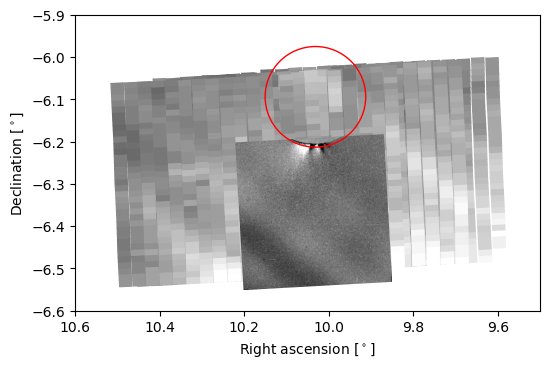

In [31]:
# w = 0    # 0.89 μm
w = 134  # 3.11 μm
# w = 254  # 5.11 μm

# normalise colormap over all cubes
norm = Normalize(vmin=0, vmax=np.percentile(data[:, w, :, :], 99), clip=True)
colors = plt.get_cmap('gray')(norm(data[:, w, :, :].flatten()))

k=0
# create figure
_, ax = plt.subplots(figsize=(6, 4))
ax.add_collection(PathCollection(paths, facecolors=colors, edgecolors=colors,zorder=0))

# --------------------------ISS ---------------------------
filter = "IR3" # select filter
filtered_meta_data = meta_data[meta_data["Filter [Cassini ISS]"] == filter]
filtered_meta_data = filtered_meta_data.iloc[-2]    # show second to last image

# Extract the 'Observation Start Time (YMDhms)' data from the filtered DataFrame
start_time = filtered_meta_data["Observation Start Time (YMDhms)"]
# Convert 'Observation Start Time (YMDhms)' to datetime
start_time_date = pd.to_datetime(filtered_meta_data['Observation Start Time (YMDhms)'])
# Calculate mid-time
mid_time = start_time_date + pd.to_timedelta(filtered_meta_data['Observation Duration (secs)'] / 2, unit='s')
ids = list(filtered_meta_data["OPUS ID"])
pds_id =filtered_meta_data["PDS ID"]


[shape, insfrm, bsight, n, bounds] = spice.getfvn("CASSINI_ISS_NAC", 4) # get fov
pform = spice.pxform("CASSINI_ISS_NAC", 'J2000', spice.str2et(str(mid_time))) # get transformation matrix from Cassini to J2000
ra_list = []
dec_list = []
for i in range(len(bounds)):
    # transform corner coordinates
    bounds[i] = spice.mxv(pform, bounds[i])
    dist, ra, dec = spice.recrad(bounds[i])
    ra_deg = np.rad2deg(ra)
    dec_deg =np.rad2deg(dec)
    ra_list.append(ra_deg)
    dec_list.append(dec_deg)

ra_list.append(ra_list[0])
dec_list.append(dec_list[0])

# load image
img = mpimg.imread(f"../data/isis_E17_subclear/{pds_id}.png")
img = np.fliplr(img.reshape(-1,3)).reshape(img.shape)

# Create path for the patch
path = Path(np.column_stack([ra_list, dec_list]))
if filter == "RED":
    fcolor ="r"
elif  filter == "BL1":
    fcolor = "blue"
elif filter == "IR1":
    fcolor = "maroon"
else:
    fcolor = "black"
patch = PathPatch(path, facecolor='none', edgecolor=None, lw=0, zorder=1)
ax.add_patch(patch)

# Display the image with the patch as clipping path
im = ax.imshow(img, interpolation='bilinear', origin='lower', cmap=None,
               extent=[min(ra_list), max(ra_list), min(dec_list), max(dec_list)],
               clip_path=patch, clip_on=True, alpha=1)

im.set_clip_path(patch)
j+=1
k += 1
ax.set_aspect('equal')
ax.set_xlim(10.6, 9.5)
ax.set_ylim(-6.6, -5.9)

# Define the center and radius of the circle for body of Enceladus
circle_center = (10.032, -6.094)  # (RA, Dec) coordinates
circle_radius = 0.119

# Create the circle patch
circle = Circle(circle_center, circle_radius, color='red', fill=False, linewidth=1, alpha=1)
ax.add_patch(circle)
ax.set_xlabel(r"Right ascension [$^\circ$]")
ax.set_ylabel(r"Declination [$^\circ$]")
spice.kclear();